In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from numpy import sin, cos, pi
from scipy.optimize import leastsq
import json
class SSRec:
    def __init__(self, doi, keywords, num_rec):
        self.url_base = "http://api.semanticscholar.org/graph/v1/paper/search?query="
        self.num_rec = num_rec
        self.rec_list = None
        self.doi = doi
        self.paperId = None
        self.embedding = []
        self.keywords = keywords
        self.reduced_embedding = None
        self.classes = []

    def setDOI(self, doi):
        self.doi = doi
    
    def setKeywords(self, keywords):
        self.keywords = keywords

    def save_state(self):
        with open("state.json", 'w') as f:
            json.dump({
                "paperId": self.paperId,
                "rec_list": list(self.rec_list),
                "embedding": self.embedding,
                "reduced_embedding": list(self.reduced_embedding),
                "classes": self.classes
            }, f)

    def getSelfEmbedding(self):
        qry = "https://api.semanticscholar.org/v1/paper/"+self.doi
        response = requests.get(qry).json()
        self.paperId = response["url"].split("/")[-1]
        qry = "https://api.semanticscholar.org/graph/v1/paper/"+self.paperId+"?fields=embedding"
        response = requests.get(qry).json()
        self.embedding = response["embedding"]["vector"]

    def getRec(self):
        kw_str = ""
        for kw in self.keywords:
            kw_str += kw.lower()
            kw_str += "+"
        offset = 0
        limit = self.num_rec
        qry = self.url_base + kw_str[:-1]+"&offset={}&limit={}&fields=title,authors,url".format(offset,limit)
        self.rec_list = requests.get(qry).json()["data"]
        self.getRecEmbeddings()

    def getRecEmbeddings(self):
        i = 0
        total = len(self.rec_list)
        while (i < total):
            dic = self.rec_list[i]
            paperId = dic["paperId"]
            qry = "https://api.semanticscholar.org/graph/v1/paper/"+paperId+"?fields=embedding"
            print("{}/{} Querying: {}".format(i, total, dic["title"]))
            response = requests.get(qry).json()
            if "error" in response.keys():
                print(response["error"])
            else:
                embedding = response["embedding"]["vector"]
                self.rec_list[i]["embedding"] = embedding
                i+=1

    def CosineSimilarity(self, vec1, vec2):
        return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

    def getSimilarityScores(self):
        for i in range(len(self.rec_list)):
            sim_score = self.CosineSimilarity(self.rec_list[i]["embedding"], self.embedding)
            self.rec_list[i]["similarity"] = sim_score

    def plotSimilarityDistribution(self):
        sim_vec = []
        for i in range(len(self.rec_list)):
            sim_vec.append(self.rec_list[i]["similarity"])
        plt.hist(self.sim_vec)
        plt.savefig("similarity-distribution.png")


    def divideRecBySimilarity(self):
        '''
        divide the recommended papers into 4 classes by similarity with the current paper
        class1: similarity >= 75%
        class2: similarity >= 50% and < 75%
        class3: similarity >= 25% and < 50%
        class4: similarity < 25%
        '''
        class1, class2, class3, class4 = [], [], [], []
        for i in range(len(self.rec_list)):
            rec_embedding = self.rec_list[i]["embedding"]
            similarity = self.CosineSimilarity(rec_embedding, self.embedding)
            if similarity >= 0.75:
                class1.append(i)
            elif similarity >= 0.5 and similarity < 0.75:
                class2.append(i)
            elif similarity >= 0.25 and similarity < 0.5:
                class3.append(i)
            else:
                class4.append(i)
        self.classes = [class1, class2, class3, class4]

    def dimensionReduction(self):
        rec_embeddings = []
        for i in range(len(self.rec_list)):
            rec_embeddings.append(self.rec_list[i]["embedding"])
        
        all_embeddings = np.concatenate((rec_embeddings, np.array(self.embedding).reshape(1, -1)), axis=0)
        print(all_embeddings.shape)
        self.reduced_embedding = TSNE(n_components = 2, random_state=0).fit_transform(all_embeddings)[:,:2]

    def find_boundary(self, x, y, n, plot_pts=1000):
        def sines(theta):
            ans = np.array([sin(i*theta)  for i in range(n+1)])
            return ans

        def cosines(theta):
            ans = np.array([cos(i*theta)  for i in range(n+1)])
            return ans

        def residual(params, x, y):
            x0 = params[0]
            y0 = params[1]
            c = params[2:]

            r_pts = ((x-x0)**2 + (y-y0)**2)**0.5

            thetas = np.arctan2((y-y0), (x-x0))
            m = np.vstack((sines(thetas), cosines(thetas))).T
            r_bound = m.dot(c)

            delta = r_pts - r_bound
            delta[delta>0] *= 10

            return delta

        # initial guess for x0 and y0
        x0 = x.mean()
        y0 = y.mean()

        params = np.zeros(2 + 2*(n+1))
        params[0] = x0
        params[1] = y0
        params[2:] += 1000

        popt, pcov = leastsq(residual, x0=params, args=(x, y),
                            ftol=1.e-12, xtol=1.e-12)

        thetas = np.linspace(0, 2*pi, plot_pts)
        m = np.vstack((sines(thetas), cosines(thetas))).T
        c = np.array(popt[2:])
        r_bound = m.dot(c)
        x_bound = popt[0] + r_bound*cos(thetas)
        y_bound = popt[1] + r_bound*sin(thetas)

        return x_bound, y_bound

    def drawClassSamples(self, classId, ax):
        label_list = ["75%~100%", "50%~75%", "25%~50%", "0~25%"]
        # x, y = self.find_boundary(self.reduced_embedding[self.classes[classId], 0], self.reduced_embedding[self.classes[classId], 1], n = 2)
        ax.scatter(self.reduced_embedding[self.classes[classId], 0], self.reduced_embedding[self.classes[classId], 1], label = label_list[classId])
        # ax.plot(x, y, '-k', lw=0.8)

    def visEmbeddings(self):
        fig, ax = plt.subplots()
        for classId in range(4):
            self.drawClassSamples(classId, ax)
        ax.scatter(self.reduced_embedding[-1, 0], self.reduced_embedding[-1, 1], marker = "*", label = "Current")
        plt.legend()
        plt.savefig("visual-embedding.png")

    def visRec(self):
        self.getSelfEmbedding()
        self.getRec()
        self.plotSimilarityDistribution()
        self.divideRecBySimilarity()
        self.dimensionReduction()
        self.visEmbeddings()

    def sortRecListBySimilarity(self):
        self.rec_list = sorted(self.rec_list, key=lambda d: d['similarity'], reverse=True) 

    def dumpToFile(self):
        tmp = []
        for i in range(len(self.rec_list)):
            tmp.append({
                "title": self.rec_list[i]["title"],
                "authors": self.rec_list[i]["authors"],
                "url": self.rec_list[i]["url"],
                "similarity": self.rec_list[i]["similarity"]
            })
        with open("editor/static/editor/json/query.json", 'w') as f:
            json.dump({"data": tmp}, f)

    def query(self):
        self.getSelfEmbedding()
        self.getRec()
        self.getSimilarityScores()
        self.sortRecListBySimilarity()
        self.dumpToFile()



In [2]:
ssr = SSRec(doi = "10.1145/3422604.3425951", keywords=['wifi', 'sensing', 'localization'], num_rec= 30)
ssr.getSelfEmbedding()
ssr.getRec()
ssr.getSimilarityScores()

0/30 Querying: Wi-CaL: WiFi Sensing and Machine Learning Based Device-Free Crowd Counting and Localization
1/30 Querying: Magicol: Indoor Localization Using Pervasive Magnetic Field and Opportunistic WiFi Sensing
2/30 Querying: Lightweight and Standalone IoT Based WiFi Sensing for Active Repositioning and Mobility
3/30 Querying: WiFi-based Multi-task Sensing
4/30 Querying: UbiTrack: enabling scalable & low-cost device localization with onboard wifi
5/30 Querying: Mobile Sensing: GPS Localization, WiFi Mapping, Applications, and Risks
6/30 Querying: Enhancing Camera-Based Multimodal Indoor Localization With Device-Free Movement Measurement Using WiFi
7/30 Querying: Compressed Multivariate Kernel Density Estimation for WiFi Fingerprint-based Localization
8/30 Querying: Fast and Reliable WiFi Fingerprint Collection for Indoor Localization
9/30 Querying: Dynamic Indoor Localization Algorithm Based on Compressed Sensing and Inertial Navigation
10/30 Querying: High-Accuracy Localization Usin

In [3]:
ssr.rec_list

[{'paperId': '0972f3f5a1f58ea86b07cd442414dd0079c8a375',
  'url': 'https://www.semanticscholar.org/paper/0972f3f5a1f58ea86b07cd442414dd0079c8a375',
  'title': 'Wi-CaL: WiFi Sensing and Machine Learning Based Device-Free Crowd Counting and Localization',
  'authors': [{'authorId': '36078123', 'name': 'Hyuckjin Choi'},
   {'authorId': '1736689', 'name': 'Manato Fujimoto'},
   {'authorId': '1865623670', 'name': 'Tomokazu Matsui'},
   {'authorId': '102237219', 'name': 'Shinya Misaki'},
   {'authorId': '1765230', 'name': 'K. Yasumoto'}],
  'embedding': [-4.505526542663574,
   -1.3173065185546875,
   -3.73213529586792,
   3.0949347019195557,
   -2.0071659088134766,
   -1.141628623008728,
   7.714229583740234,
   -1.6146888732910156,
   1.908630132675171,
   -2.425530195236206,
   -1.2481021881103516,
   0.6046594381332397,
   3.936742067337036,
   -2.356025457382202,
   -3.617619514465332,
   0.5943506956100464,
   -2.468681812286377,
   3.098149538040161,
   3.1495113372802734,
   -0.050950

In [18]:
import networkx as nx
G = nx.Graph()
G.add_node(0, title = "Current", similarity = 1)
# for i in range(1, len(ssr.rec_list)+1):
#     G.add_node(i, title = ssr.rec_list[i-1]["title"], similarity = ssr.rec_list[i-1]["similarity"])
#     G.add_edge(0, i, similarity = ssr.rec_list[i-1]["similarity"])

In [7]:
G.nodes.data()

NodeDataView({0: {'title': 'Current', 'similarity': 1}})

In [19]:
pos = nx.spring_layout(G,weight='similarity')

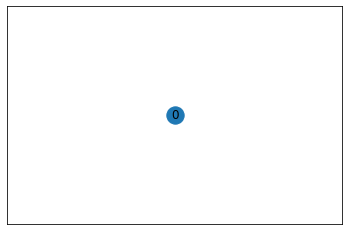

In [20]:
nx.draw_networkx(G,pos)

In [10]:
adjusted_node_size = dict([(i, ssr.rec_list[i-1]["similarity"]*50) for i in range(1, len(ssr.rec_list)+1)])
adjusted_node_size[0] = 1*50
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [21]:
#Choose a title!
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
title = 'Citation Graph'
#Establish which categories will appear when hovering over each node
color_palette = Reds8
HOVER_TOOLTIPS = [("title", "@title")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, pos, scale=10, center=(0, 0))
#Set node size and color
network_graph.node_renderer.glyph = Circle(size=50, fill_color="Blue")

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
#save(plot, filename=f"{title}.html")

# Learn Networkx

In [41]:
import networkx as nx
G = nx.Graph()

In [42]:
G.add_node(1)

In [43]:
G.add_nodes_from([2, 3])

In [44]:
G.add_nodes_from([
    (4, {"color": "red"}),
    (5, {"color": "green"}),
])

In [45]:
H = nx.path_graph(10)
G.add_nodes_from(H)

In [46]:
G.add_edge(1, 2)
e = (2, 3)
G.add_edge(*e)  # unpack edge tuple*
G.add_edges_from([(1, 2), (1, 3)])
G.add_edges_from(H.edges)

In [47]:
G.number_of_nodes()

10

In [48]:
G.number_of_edges()

10

In [50]:
list(G.nodes), list(G.edges)

([1, 2, 3, 4, 5, 0, 6, 7, 8, 9],
 [(1, 2),
  (1, 3),
  (1, 0),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9)])

# Learn Bokeh

In [25]:
!pip install bokeh

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [12]:
from bokeh.plotting import figure, show

# prepare some data
x = [1, 2, 3, 4, 5]
y = [6, 7, 2, 4, 5]

# create a new plot with a title and axis labels
p = figure(title="Simple line example", x_axis_label="x", y_axis_label="y")

# add a line renderer with legend and line thickness
p.line(x, y, legend_label="Temp.", line_width=2)

# show the results
show(p)

In [28]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.plotting import figure, from_networkx

G = nx.karate_club_graph()

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1),
              tools="", toolbar_location=None)

graph = from_networkx(G, nx.spring_layout, scale=2, center=(0,0))
plot.renderers.append(graph)

output_file("networkx_graph.html")
show(plot)

In [15]:
import networkx as nx

from bokeh.io import output_file, show
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

G=nx.karate_club_graph()

plot = Plot(width=400, height=400,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Graph Interaction Demonstration"

plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

plot.renderers.append(graph_renderer)

output_file("interactive_graphs.html")
show(plot)

In [71]:
import networkx as nx

from bokeh.io import output_file, show,output_notebook
from bokeh.models import (BoxZoomTool, Circle, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import from_networkx

# Prepare Data
G = nx.karate_club_graph()

SAME_CLUB_COLOR, DIFFERENT_CLUB_COLOR = "black", "red"
edge_attrs = {}

for start_node, end_node, _ in G.edges(data=True):
    edge_color = SAME_CLUB_COLOR if G.nodes[start_node]["club"] == G.nodes[end_node]["club"] else DIFFERENT_CLUB_COLOR
    edge_attrs[(start_node, end_node)] = edge_color

nx.set_edge_attributes(G, edge_attrs, "edge_color")

# Show with Bokeh
plot = Plot(width=400, height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Graph Interaction Demonstration"

node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("club", "@club")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.edge_renderer.glyph = MultiLine(line_color="edge_color", line_alpha=0.8, line_width=1)
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...